In [35]:
import os
import sys
import math
import random

from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append("../../")

from helpers.assess import resolve_sample_weight, make_classification_report
from helpers.split import make_train_test_split, tag_label_feature_split


from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)

In [36]:
file = os.path.join(Path().absolute().parents[1], 'datasets', 'dataset_10_melspecs.pickle.bz2')
df = pd.read_pickle(file)

In [37]:
def split10(array):
    return np.array_split(array[:, 0:680], 10, axis=1)

In [42]:
df['melspec'] = df['melspec'].apply(split10)
df = df.explode(['melspec']).reset_index(drop=True)
df1 = df.sample(frac=1) #shuffle

In [43]:
_, (y, le), X = tag_label_feature_split(
    df1, label_format="encoded"
)

In [44]:
def crop_center(X,cropx,cropy):
    _, y,x = X.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return X[:, starty:starty+cropy,startx:startx+cropx]

In [45]:
# extract 2D numpy array from pandas dataframe
X = np.array(list(X.to_numpy()[:,0]))
print(X.shape)
# choosing ~5s clip to make square 96x96 spectrogram frame
# X = crop_center(X, 341, 96) # 683 is around 30s

print(X.shape)

scaler = StandardScaler()
# flatten 2D array to fit to "overall" mean / variance
scaler.fit(X.reshape(-1,1))
# must be reshaped for transformation then restored to original shape
X = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

# add a dimension from (n, 96, 96) to (n, 96, 96, 1)
X = np.expand_dims(X, axis=-1)

(213510, 96, 68)
(213510, 96, 68)


In [46]:
print(X.shape)

(213510, 96, 68, 1)


In [47]:
X_train, X_test, y_train, y_test = make_train_test_split(
        X, y, test_size=0.1, random_state=10, stratify=y
    )

X_train, X_validation, y_train, y_validation = make_train_test_split(
        X_train, y_train, test_size=0.3, random_state=10, stratify=y_train
    )

class_weight={i:c  for i,c in enumerate(compute_class_weight(class_weight='balanced',classes=le.transform(le.classes_),y=y_train))}

In [48]:
print(np.squeeze(X_train, axis = -1).shape)

(134511, 96, 68)


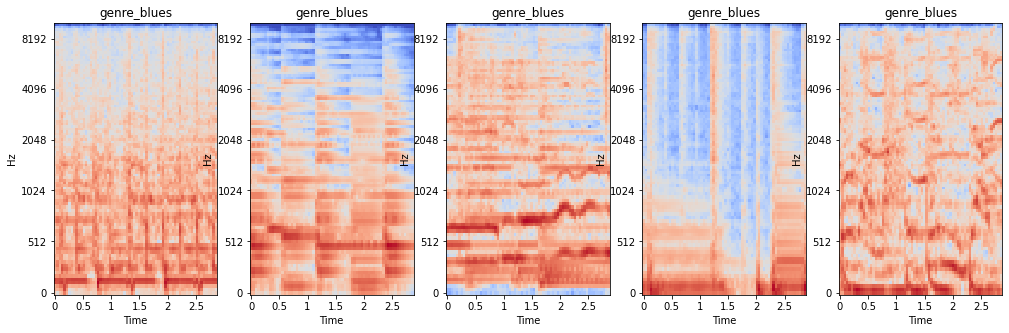

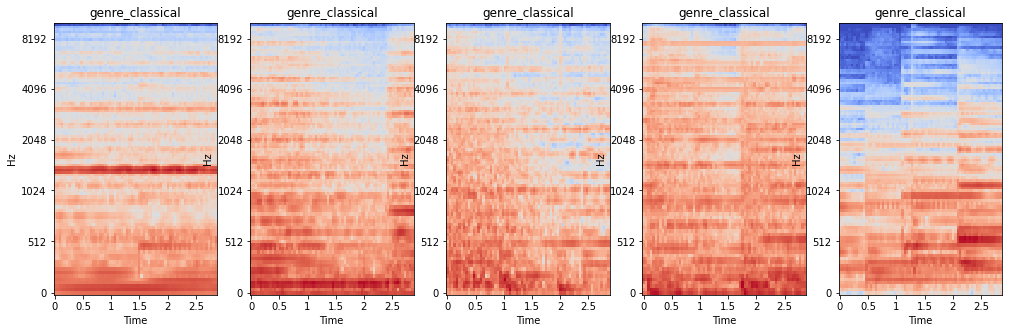

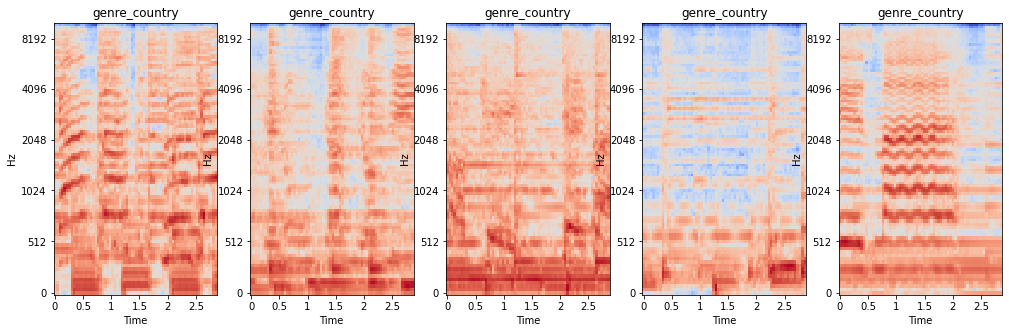

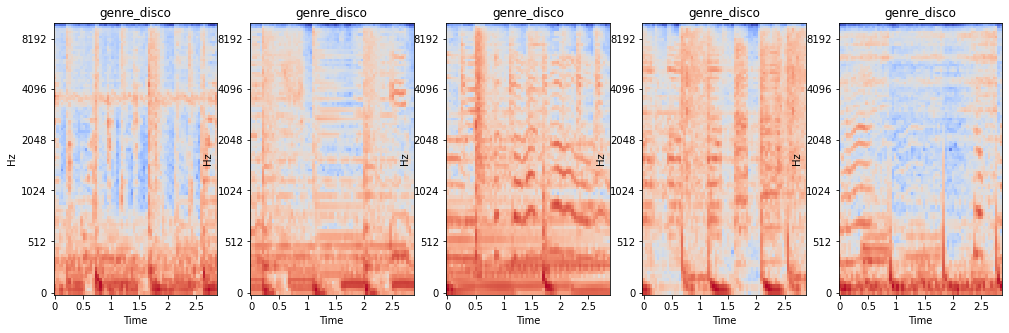

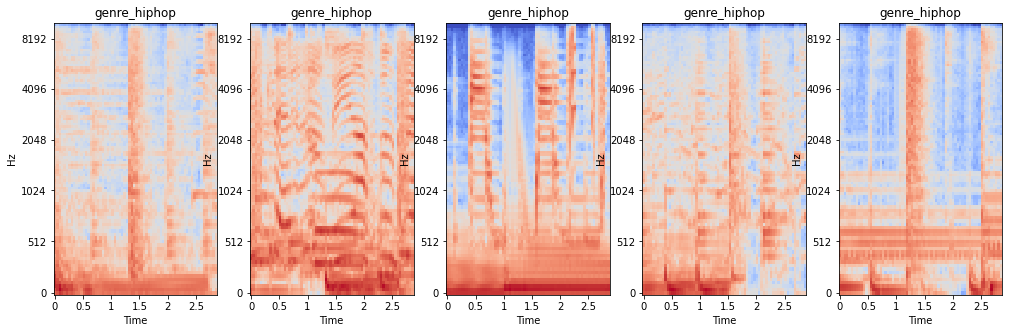

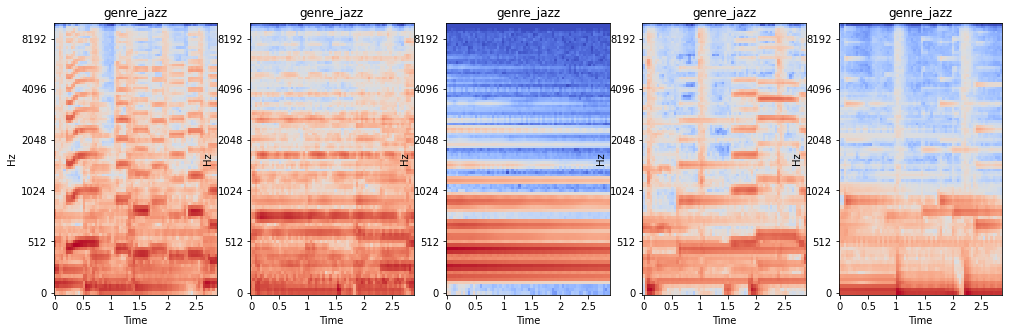

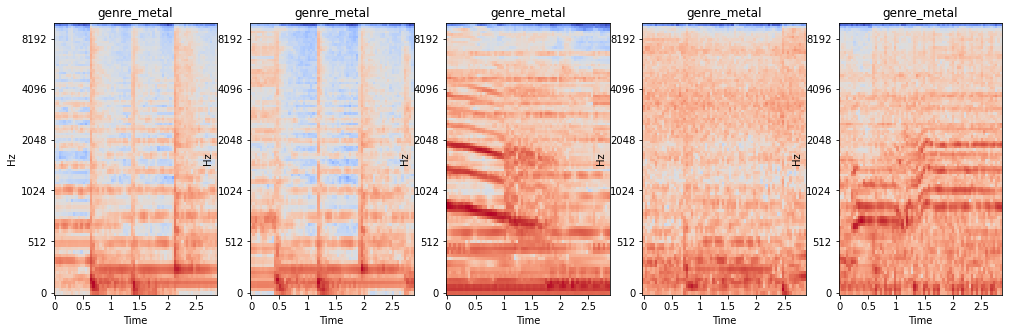

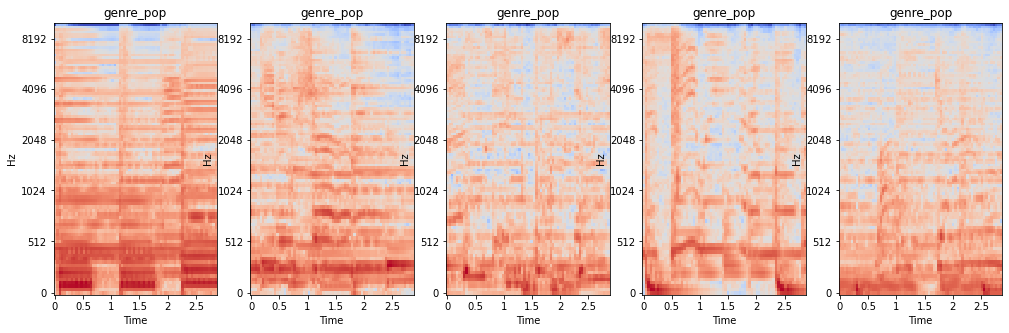

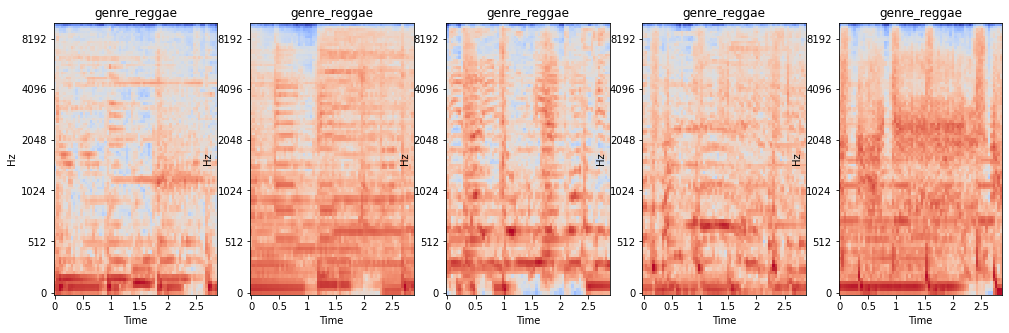

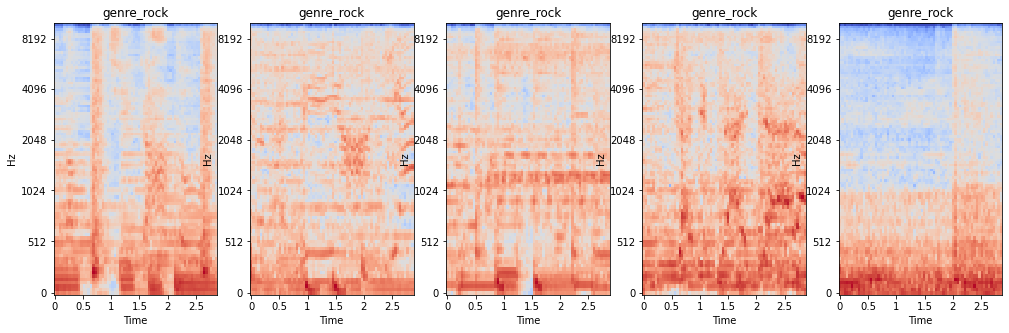

In [49]:
import librosa
import librosa.display

for l in range(10):
    nrows, ncols = 1,5 #print first 4 images
    f, axs = plt.subplots(nrows, ncols, figsize=(17,5))
    tempArr = X_train[y_train == l, :]
    label = le.inverse_transform([l])[0]
    num = 0
    for i in range(ncols):
        img = librosa.display.specshow(np.squeeze(tempArr[num], axis = -1), x_axis='time',
                            y_axis='mel', sr=12000,
                            fmax=10000, ax=axs[i])
        axs[i].set(title=label)
        num += 1
    plt.show()

In [50]:
print(X_train.shape)

(134511, 96, 68, 1)


In [51]:
def build_model(
    filters=[64],
    kernal_size=[16],
    strides=(1, 1),
    padding='same',
    activation='relu',
    pool_size=(2,2),
    batch_normalization=False,
    batch_axis=None,
    dense_units=[1024],
    dropout_rate=0.5,
    input_shape=(None, 96, 96, 1),
    last_activation=None
):
    param = {
        'filters': filters,
        'kernal_size': kernal_size,
        'strides': strides,
        'padding': padding,
        'activation': activation,
        'pool_size': pool_size,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate,
        'input_shape': input_shape,
        'batch_normalization': batch_normalization,
        'batch_axis': batch_axis,
        'last_activation': last_activation
    }
    model = tf.keras.Sequential()

    for i in range(len(filters)):
        model.add(
            tf.keras.layers.Conv2D(
                filters=filters[i],
                kernel_size=kernal_size[i],
                strides=strides,
                padding=padding,
                name=f'conv_{i}',
                activation=activation
            )
        )
        
        if batch_normalization:
            tf.keras.layers.BatchNormalization(batch_axis[i])

        model.add(
            tf.keras.layers.MaxPool2D(
                pool_size=pool_size,
                name=f'pool_{i}'
            )
        )

    model.add(tf.keras.layers.Flatten()) 

    for l in range(len(dense_units)):
        model.add( 
            tf.keras.layers.Dense(
                units=dense_units[l],
                name=f'fc_{l}', 
                activation=activation
            )
        )

    if dropout_rate:
        model.add(
            tf.keras.layers.Dropout(
                rate=dropout_rate
            )
        )

    model.add(
        tf.keras.layers.Dense(
            units=10,
            name='fc_last',
            activation=last_activation
        )
    )

    tf.random.set_seed(1)
    model.build(input_shape=input_shape)
    print(model.summary())

    return model, param



using model from https://towardsdatascience.com/music-genre-recognition-using-convolutional-neural-networks-cnn-part-1-212c6b93da76

In [52]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [56]:
model3, param3 = build_model(
    filters=[8, 16, 32, 64, 128],
    kernal_size=[(3,3), (3,3), (3,3), (3,3), (3,3)],
    strides=(1, 1),
    padding='same',
    activation='relu',
    batch_normalization=True,
    batch_axis=[3, 3, 3, -1, -1],
    pool_size=(2,2),
    dense_units=[],
    dropout_rate=0.3,
    input_shape=(None, 96, 68, 1),
    last_activation='softmax'
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 96, 68, 8)         80        
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 48, 34, 8)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 48, 34, 16)        1168      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 24, 17, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 17, 32)        4640      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 8, 32)         0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 8, 64)        

In [59]:
learning_rate = 0.0005
epoch = 100

param3['learning_rate'] = learning_rate
param3['epoch'] = epoch

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', get_f1]
)

In [60]:
tf.random.set_seed(1234)
np.random.seed(1234)
hist3 = model3.fit(
    X_train,
    y_train,
    epochs=epoch, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight,
    # verbose=0
)

Epoch 1/100
4204/4204 [==============================] - 27s 6ms/step - loss: 1.3843 - accuracy: 0.4783 - get_f1: 3.8884 - val_loss: 1.5119 - val_accuracy: 0.4470 - val_get_f1: 3.7931
Epoch 2/100
4204/4204 [==============================] - 27s 6ms/step - loss: 1.3070 - accuracy: 0.4944 - get_f1: 3.6678 - val_loss: 1.3437 - val_accuracy: 0.5187 - val_get_f1: 3.6155
Epoch 3/100
4204/4204 [==============================] - 26s 6ms/step - loss: 1.2643 - accuracy: 0.5022 - get_f1: 3.5543 - val_loss: 1.3656 - val_accuracy: 0.5049 - val_get_f1: 3.5265
Epoch 4/100
4204/4204 [==============================] - 27s 6ms/step - loss: 1.2208 - accuracy: 0.5110 - get_f1: 3.4438 - val_loss: 1.3655 - val_accuracy: 0.5185 - val_get_f1: 3.3643
Epoch 5/100
4204/4204 [==============================] - 26s 6ms/step - loss: 1.1757 - accuracy: 0.5194 - get_f1: 3.3296 - val_loss: 1.3425 - val_accuracy: 0.5185 - val_get_f1: 3.4735
Epoch 6/100
4204/4204 [==============================] - 27s 6ms/step - loss: 1.

Text(0.5, 1.0, 'Accuracy')

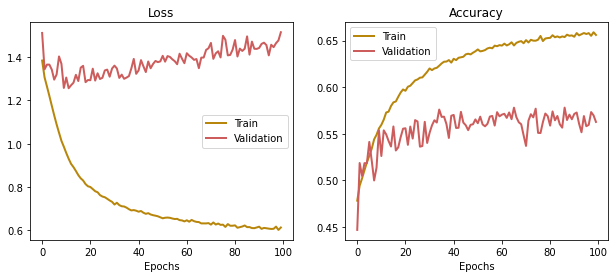

In [61]:
# grab history
history3 = hist3.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history3['loss'], lw=2, color='darkgoldenrod')
plt.plot(history3['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss')

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history3['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history3['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy')

In [63]:
y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [80]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model3,
    x = X_test,
    save_result=True,
    label_encoder=le,
    model_name='CNN_melspec_partitioned_3s_1',
    dataset_name='dataset_10_melspecs_partitioned',
    phase='train',
    additional_result_param=param3,
    repeat=True,
    result_filename='alvin_melspec_CNN.json'
)


c:\Users\alvin\OneDrive - UCLA IT Services\Berkeley MIDS\W207\final_project\member_workspaces\alvin\..\..\results\alvin_melspec_CNN.json
file exist, reading json
record saved


'                   precision  recall  f1-score  support   mcc\n                                                             \n      genre_blues       0.15    0.14      0.14      468  0.13\n  genre_classical       0.82    0.83      0.83     5276  0.77\n    genre_country       0.35    0.44      0.39      409  0.38\n      genre_disco       0.34    0.42      0.38      361  0.37\n     genre_hiphop       0.51    0.74      0.60     2126  0.56\n       genre_jazz       0.38    0.57      0.46     1552  0.42\n      genre_metal       0.38    0.67      0.49      831  0.48\n        genre_pop       0.53    0.39      0.45     5343  0.31\n     genre_reggae       0.47    0.57      0.52      985  0.50\n       genre_rock       0.60    0.41      0.49     4000  0.41\n                                                             \n         accuracy                         0.56    21351  0.49\n        macro avg       0.45    0.52      0.47    21351      \n     weighted avg       0.58    0.56      0.56    2135

In [82]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model3,
    x = X_test,
    label_encoder=le,
    print_report=True
)

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.15    0.14      0.14      468  0.13
  genre_classical       0.82    0.83      0.83     5276  0.77
    genre_country       0.35    0.44      0.39      409  0.38
      genre_disco       0.34    0.42      0.38      361  0.37
     genre_hiphop       0.51    0.74      0.60     2126  0.56
       genre_jazz       0.38    0.57      0.46     1552  0.42
      genre_metal       0.38    0.67      0.49      831  0.48
        genre_pop       0.53    0.39      0.45     5343  0.31
     genre_reggae       0.47    0.57      0.52      985  0.50
       genre_rock       0.60    0.41      0.49     4000  0.41
                                                             
         accuracy                         0.56    21351  0.49
        macro avg       0.45    0.52      0.47    21351      
     weighted avg       0.58    0.56      0.56    21351      
        

'                   precision  recall  f1-score  support   mcc\n                                                             \n      genre_blues       0.15    0.14      0.14      468  0.13\n  genre_classical       0.82    0.83      0.83     5276  0.77\n    genre_country       0.35    0.44      0.39      409  0.38\n      genre_disco       0.34    0.42      0.38      361  0.37\n     genre_hiphop       0.51    0.74      0.60     2126  0.56\n       genre_jazz       0.38    0.57      0.46     1552  0.42\n      genre_metal       0.38    0.67      0.49      831  0.48\n        genre_pop       0.53    0.39      0.45     5343  0.31\n     genre_reggae       0.47    0.57      0.52      985  0.50\n       genre_rock       0.60    0.41      0.49     4000  0.41\n                                                             \n         accuracy                         0.56    21351  0.49\n        macro avg       0.45    0.52      0.47    21351      \n     weighted avg       0.58    0.56      0.56    2135